# Standard Analysis Script

This script analyzes the standard data of any system:

- Temperature
- Pressure
- Density
- Potential Energy
- Kinetic Energy
- Total Energy
- Mindistance to periodic images
- Protein RMSD
- Protein RMSF

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import MDAnalysis as mda
import MDAnalysis.transformations as trans
import nglview as nv

prefix = "../Sample_files/TRPV2_test/"
traj = f"{prefix}step7_production.xtc"
top = f"{prefix}step7_production.tpr"
energy = f"{prefix}step7_production.edr"

lipid_list = ["CHOL", "POPC", "PAPC", "PAPE", "DPSM", "PNGS", "POPA", "PAP1", "PAP6"]

in_memory = True
memory_step = 1


Bad key text.latex.preview in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

# Center trajectory

In [2]:
step1 = f'echo System | gmx trjconv -f {traj} -s {top} -n {prefix}index.ndx -pbc nojump -o {prefix}tra1.xtc'
os.system(step1)
os.system(f'echo Protein System | gmx trjconv -f {prefix}tra1.xtc -s {top} -n {prefix}index.ndx -fit translation -o {prefix}tra2.xtc')
os.system(f'rm {prefix}tra1.xtc')
final_step = f'echo System | gmx trjconv -f {prefix}tra2.xtc -s {top} -n {prefix}index.ndx -pbc mol -o {prefix}centered_step7_production.xtc'
os.system(final_step)
os.system(f'rm {prefix}tra2.xtc')
traj = f"{prefix}centered_step7_production.xtc"

                      :-) GROMACS - gmx trjconv, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx trjconv -f ../Sample_files/TRPV2_test/step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -n ../Sample_files/TRPV2_test/index.ndx -pbc nojump -o ../Sample_files/TRPV2_test/tra1.xtc

Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Gro

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


Reading frame    4000 time 4000000.000    ->  frame   3999 time 3999000.000      

Last written: frame   4726 time 4726000.000


GROMACS reminds you: "Contemplating answers that could break my bonds." (Peter Hammill)

                      :-) GROMACS - gmx trjconv, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx trjconv -f ../Sample_files/TRPV2_test/tra2.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -n ../Sample_files/TRPV2_test/index.ndx -pbc mol -o ../Sample_files/TRPV2_test/centered_step7_production.xtc

Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for translational fit
Selected 1: 'Protein'
Select group for output
Selected 0: 'System'


Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H) has     0 elements
Group     8 (      SideChain) has  6320 elements
Group     9 (    SideChain-H) has  6320 elements
Group    10 (    Prot-Masses) has  6320 elements
Group    11 (    non-Protein) has 86678 elements
Group    12 (          Other) has 84690 elements
Group    13 (           CHOL) has  3808 elements
Group    14 (           POPC) has  2136 elements
Group    15 (           PAPC) has   546 elements
Group    16 (           PAPE) has  1755 elements
Group    17 (           DPSM) has   935 elements
Group    18 (           PNGS) has  1125 elements
Group    19 (           PAPS) has  2756 elements
Group    20 (       

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'




Last written: frame   4726 time 4726000.000


GROMACS reminds you: "It is Lunchtime" (A.R. Van Buuren)



In [3]:
traj = f"{prefix}centered_step7_production.xtc"
u = mda.Universe(top, traj, in_memory=in_memory, in_memory_step=memory_step)
wrapped = nv.show_mdanalysis(u)
wrapped.add_representation('point', 'not protein')
wrapped.center()
wrapped

/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/XDR.py:237: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=4726)

## Temperature, pressure, density, volume, energies

In [4]:
try:
    os.mkdir("Data_Analysis")
    print("Folder Data_Analysis created")
except OSError as error:
    print("Can't create folder: folder Data_Analysis already exists")

try:
    os.mkdir("Data_Analysis/Stats")
    print("Folder Data_Analysis/Stats created")
except OSError as error:
    print("Can't create folder: folder Data_Analysis/Stats already exists")


variables = ["temperature", "density", "pressure", "volume", "potential", "kinetic-en", "total-energy"]

for variable in variables:
    os.system(f"echo {variable}|gmx energy -f {energy} -o Data_Analysis/Stats/{variable}.xvg")

Can't create folder: folder Data_Analysis already exists
Can't create folder: folder Data_Analysis/Stats already exists

Statistics over 236300001 steps [ 0.0000 through 4726000.0000 ps ], 1 data sets
All statistics are over 2363001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 309.625    0.00047    1.10186 0.000971898  (K)

Statistics over 236300001 steps [ 0.0000 through 4726000.0000 ps ], 1 data sets
All statistics are over 2363001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1048.34     0.0065   0.884602 -0.0238294  (kg/m^3)

Statistics over 236300001 steps [ 0.0000 through 4726000.0000 ps ], 1 data sets
All statistics are over 2363001 points

Energy                      Average   Err.Est.       RMSD  Tot-Dr

                       :-) GROMACS - gmx energy, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx energy -f ../Sample_files/TRPV2_test/step7_production.edr -o Data_Analysis/Stats/temperature.xvg

Opened ../Sample_files/TRPV2_test/step7_production.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  G96Angle         3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-(SR)          6  Coulomb-(SR)     7  Potential        8  Kinetic-En.   
  9  Total-Energy    10  Conserved-En.   11  Temperature     12  Pressure      
 13  Constr.-rmsd    14  Box-X           15  Box-Y           16  Box-Z         
 17  Volume          18  Densi


Statistics over 236300001 steps [ 0.0000 through 4726000.0000 ps ], 1 data sets
All statistics are over 2363001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Total Energy             -2.03523e+06        130    2520.88   -881.693  (kJ/mol)


Last energy frame read 4726 time 4726000.000         

GROMACS reminds you: "Art is what you can get away with." (Andy Warhol)



In [5]:
#Function to read .xvg files into a proper DataFrame to plot later, removing the header, first column is time, second is the variable
def read_xvg(file, x_name, y_name, skip_lines):
    data = {x_name: [], y_name:[]} #Empty dict to store the data
    temp_file = open(file, 'r')
    temp_lines = temp_file.readlines()[skip_lines:] #This removes header lines

    for line in temp_lines: #Iterate, split data by space, get first number (time) and second (variable) and store in dictionary
        values = line.split()
        data[x_name].append(float(values[0])); data[y_name].append(float(values[1]))

    df = pd.DataFrame(data)
    return df

#Function to get average of variable in a window-sliding fashion
def get_avg(df, column_name, window):
    df['Avg'] = df[column_name]
    for i in range(len(df[column_name])):
        if i < window:
            df['Avg'][i] = None #Ignore rows until window size
        else:
            df['Avg'][i] = np.mean(df[column_name][(i-window):i]) #Add mean column
    return df

In [6]:
#Terms to plot for quality analysis
dict_terms = {'temperature': 'Temperature (K)', 'pressure': 'Pressure (bars)', 
              'volume': 'Volume ($nm3$)', 'density': 'Density (kg/$nm^3$)', 
              'potential': 'Energy (kJ/mol)', 'kinetic-en': 'Energy (kJ/mol)'}

for k,v in dict_terms.items():
    term_df = read_xvg(f"./Data_Analysis/Stats/{k}.xvg", 'Time', k, 24) #Read file .xvg into a dataframe

    term_df = get_avg(term_df, k, 25) #Get avgs
    
    term_df["Time"] = term_df["Time"]/1000

    #Plot
    plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
    sns_term = sns.lineplot(x='Time', y=k, data=term_df) #Plot term over time
    sns_temp = sns.lineplot(x='Time', y='Avg', data=term_df) #Plot avg term over time
    sns_temp.set_xlabel('Time (ns)')
    y_ax_label = v #get y axis name based on term being plotted
    sns_temp.set_ylabel(y_ax_label) #Change y axis label
    fig = sns_temp.get_figure()  # Get figure
    output_name = f"./Data_Analysis/Stats/{k}.svg"
    fig.savefig(output_name,dpi=300, bbox_inches='tight')  # Save graph in folder
    plt.clf()  # Erase plot to avoid stacking one on each other

/tmp/ipykernel_373082/2264121682.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
/tmp/ipykernel_373082/2264121682.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
/tmp/ipykernel_373082/2264121682.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are d

<Figure size 432x288 with 0 Axes>

## Protein RMSD, RMSF, and radius of gyration

In [7]:
#Load trajectory as MDA universe object
u = mda.Universe(top, traj, in_memory=in_memory, in_memory_step=memory_step)

#Store times from each frame of the trajectory
times = [ts.time for ts in u.trajectory]

print("Loaded trajectory: {}".format(u))
print("Number of frames: {}".format(len(u.trajectory)))

Loaded trajectory: <Universe with 92998 atoms>
Number of frames: 4727


In [9]:
from MDAnalysis.analysis import rms, align
#RMSD
R = rms.RMSD(u,  # coordinates to align
         u,  # reference coordinates
         select="protein and name BB",
         ref_frame=0) #frame index of the reference
R.run()


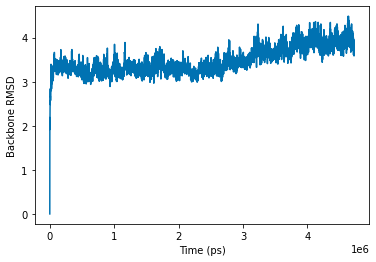

In [10]:
df = pd.DataFrame(R.results.rmsd, columns=["Frame", "Time (ps)", "Backbone RMSD"])

ax = sns.lineplot(x="Time (ps)",  y="Backbone RMSD", data=df)
fig = ax.get_figure()  # Get figure
fig.savefig("./Data_Analysis/Stats/RMSD.svg")

In [11]:
#RSMF
average = align.AverageStructure(u,u, select="protein and name BB", ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref, select="protein and name BB", in_memoery=True).run()

BB = u.select_atoms("protein and name BB")
R2 = rms.RMSF(BB).run()

/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/apmlab/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


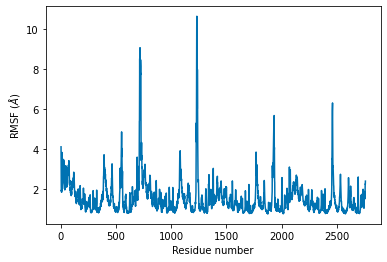

In [12]:
ax=sns.lineplot(BB.resids, R2.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
fig = ax.get_figure()  # Get figure
fig.savefig("./Data_Analysis/Stats/RMSF.svg")
#plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='X')
#plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='X')
#plt.legend();

In [13]:
#Radius of gyration
os.system(f"echo 'protein' | gmx gyrate -f {traj} -s {top} -o './Data_Analysis/Stats/gyration.xvg'")

                       :-) GROMACS - gmx gyrate, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx gyrate -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -o ./Data_Analysis/Stats/gyration.xvg

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H) has     0 elements
Group     8 (  

Selected 1: 'Protein'




GROMACS reminds you: "In science, truth always wins." (Max Perutz)



0

In [14]:
#Plot
term_df = read_xvg(f"./Data_Analysis/Stats/gyration.xvg", 'Time', "gyration", 27) #Read file .xvg into a dataframe
    
term_df["Time"] = term_df["Time"]/1000

plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
sns_term = sns.lineplot(x='Time', y="gyration", data=term_df) #Plot term over time
sns_term.set_xlabel('Time (ns)')
sns_term.set_ylabel('Radius of Gyration (nm)') #Change y axis label
fig = sns_term.get_figure()  # Get figure
output_name = "./Data_Analysis/Stats/gyration.png"
fig.savefig(output_name,dpi=300, bbox_inches='tight')  # Save graph in folder
plt.clf()  # Erase plot to avoid stacking one on each other

/tmp/ipykernel_373082/394098511.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########


<Figure size 432x288 with 0 Axes>